In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, GRU, LSTM, Embedding, Conv1D, GlobalAveragePooling1D

Definition of a plot function for training result visualization

In [ ]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)
    
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)
    
    plt.show();

## Preprocessing of the data

We get the IMDB dataset directly from the tensorflow_datasets API

In [ ]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteQT8XW1/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteQT8XW1/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteQT8XW1/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


We build train and test sets, getting both the string input data as well as the labels

In [ ]:
train_data, test_data = datasets['train'], datasets['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

We can check some values of the data to have a good understanding of it

In [ ]:
training_sentences[0]

'b"This was an absolutely terrible movie. Don\'t be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie\'s ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor\'s like Christopher Walken\'s good name. I could barely sit through it."'

In [ ]:
training_labels[0]

0

We create, from the text reviews, padding sequences of token values

In [ ]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

Have a look to some values in order to understand how we go from text sentences to sequences of tokens and, finally, to zero-padded sequences

In [ ]:
testing_sentences[20]

'b"I really tried, but this movie just didn\'t work for me. The action scenes were dull, the acting was surprisingly poor, and some of these characters were TOO stereotypical to even be funny. Pam Grier tries, but when you have nothing to work with, even her considerable talent cannot prevent a disaster. Even by the standards of this weak genre, this film is pretty bad."'

In [ ]:
print(testing_sequences[20])
print(f"length of the sequence: {len(testing_sequences[20])}")

[59, 11, 68, 812, 19, 12, 18, 43, 330, 157, 16, 73, 2, 204, 140, 72, 767, 2, 116, 14, 1255, 344, 3, 50, 5, 135, 106, 72, 100, 2794, 6, 62, 29, 162, 8844, 1, 506, 19, 55, 23, 28, 163, 6, 157, 17, 62, 40, 4452, 682, 577, 3673, 4, 1712, 62, 33, 2, 1574, 5, 12, 830, 517, 12, 20, 7, 184, 80]
length of the sequence: 66


In [ ]:
print(testing_padded[20])
print(f"length of the sequence: {len(testing_padded[20])}")

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   59   11
   68  812   19   12   18   43  330  157   16   73    2  204  140   72
  767    2  116   14 1255  344    3   50    5  135  106   72  100 2794
    6   62   29  162 8844    1  506   19   55   23   28  163    6  157
   17   62   40 4452  682  577 3673    4 1712   62   33    2 1574    5
   12  830  517   12   20    7  184   80]
length of the sequence: 120


The *reverse_word_index* function allows to transform the padded sequence into the original text. The padded-zero are translated into "*?*" and the unknown words into "*\<OOV\>*"

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of 

## Neural network model with GRU

Build a neural network using at least one GRU layer

(you may have a look at https://keras.io/api/layers/)

In [ ]:
# Model definition with GRU
model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Dropout(0.5),
    Bidirectional(GRU(32)),
    Dense(6, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
dropout (Dropout)            (None, 120, 16)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                9600      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
_________________________________________________________________
dropout_1 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
________________________________________________

In [ ]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 79s 96ms/step - loss: 0.6933 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4999
Epoch 2/50
782/782 [==============================] - 74s 95ms/step - loss: 0.6034 - accuracy: 0.6630 - val_loss: 0.4233 - val_accuracy: 0.8222
Epoch 3/50
782/782 [==============================] - 75s 96ms/step - loss: 0.4182 - accuracy: 0.8235 - val_loss: 0.3532 - val_accuracy: 0.8473
Epoch 4/50
782/782 [==============================] - 75s 96ms/step - loss: 0.3634 - accuracy: 0.8555 - val_loss: 0.3407 - val_accuracy: 0.8503
Epoch 5/50
782/782 [==============================] - 74s 94ms/step - loss: 0.3317 - accuracy: 0.8678 - val_loss: 0.3548 - val_accuracy: 0.8440
Epoch 6/50
782/782 [==============================] - 76s 97ms/step - loss: 0.3074 - accuracy: 0.8799 - val_loss: 0.3613 - val_accuracy: 0.8465
Epoch 7/50
782/782 [==============================] - 74s 95ms/step - loss: 0.2874 - accuracy: 0.8896 - val_loss: 0.4037 - val_accuracy:

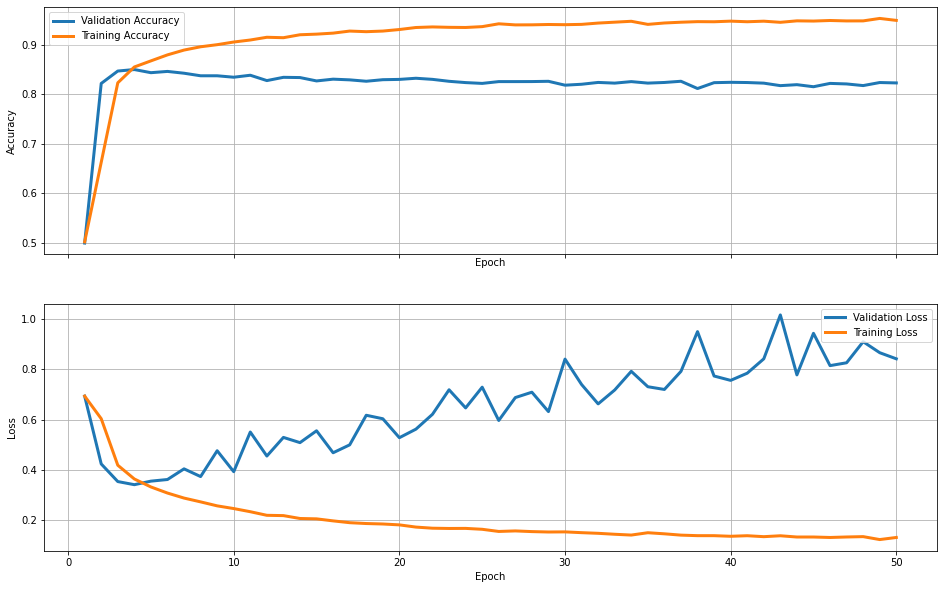

In [ ]:
plot_results(history)

## Neural network model with LSTM

Build a neural network using at least one LSTM layer

(you may have a look at https://keras.io/api/layers/)

In [ ]:
# Model Definition with LSTM
model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(32)),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 76s 92ms/step - loss: 0.4956 - accuracy: 0.7393 - val_loss: 0.3506 - val_accuracy: 0.8481
Epoch 2/50
782/782 [==============================] - 71s 91ms/step - loss: 0.3002 - accuracy: 0.8774 - val_loss: 0.3535 - val_accuracy: 0.8490
Epoch 3/50
782/782 [==============================] - 71s 91ms/step - loss: 0.2306 - accuracy: 0.9092 - val_loss: 0.3653 - val_accuracy: 0.8429
Epoch 4/50
782/782 [==============================] - 71s 91ms/step - loss: 0.1650 - accuracy: 0.9396 - val_loss: 0.4397 - val_accuracy: 0.8348
Epoch 5/50
782/782 [==============================] - 70s 90ms/step - loss: 0.1113 - accuracy: 0.9612 - val_loss: 0.5074 - val_accuracy: 0.8301
Epoch 6/50
782/782 [==============================] - 70s 90ms/step - loss: 0.0731 - accuracy: 0.9762 - val_loss: 0.5531 - val_accuracy: 0.8196
Epoch 7/50
782/782 [==============================] - 71s 90ms/step - loss: 0.0466 - accuracy: 0.9848 - val_loss: 0.7607 - val_accuracy:

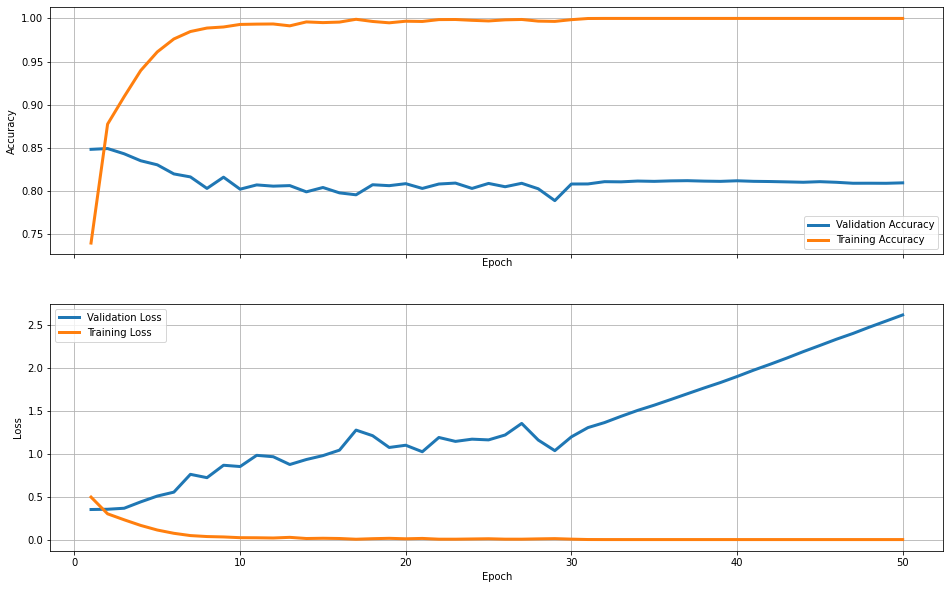

In [ ]:
plot_results(history)

## Neural network model with Convolution

Build a neural network using a Conv1D layer and a Pooling Layer

(you may have a look at https://keras.io/api/layers/)

In [ ]:
# Model Definition with Conv1D
model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Conv1D(128, 5, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 13s 16ms/step - loss: 0.4325 - accuracy: 0.7959 - val_loss: 0.3469 - val_accuracy: 0.8473
Epoch 2/50
782/782 [==============================] - 12s 16ms/step - loss: 0.2764 - accuracy: 0.8874 - val_loss: 0.3596 - val_accuracy: 0.8435
Epoch 3/50
782/782 [==============================] - 13s 16ms/step - loss: 0.2251 - accuracy: 0.9126 - val_loss: 0.3928 - val_accuracy: 0.8361
Epoch 4/50
782/782 [==============================] - 13s 17ms/step - loss: 0.1888 - accuracy: 0.9298 - val_loss: 0.4202 - val_accuracy: 0.8299
Epoch 5/50
782/782 [==============================] - 13s 17ms/step - loss: 0.1580 - accuracy: 0.9423 - val_loss: 0.4627 - val_accuracy: 0.8235
Epoch 6/50
782/782 [==============================] - 13s 16ms/step - loss: 0.1261 - accuracy: 0.9572 - val_loss: 0.5396 - val_accuracy: 0.8168
Epoch 7/50
782/782 [==============================] - 13s 17ms/step - loss: 0.1006 - accuracy: 0.9668 - val_loss: 0.6331 - val_accuracy:

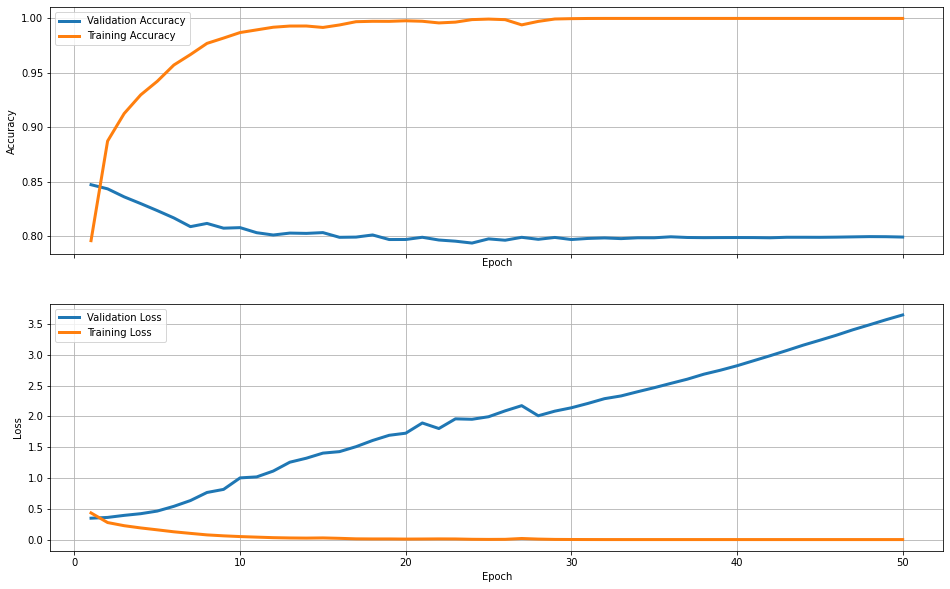

In [ ]:
plot_results(history)

Reference:

https://www.coursera.org/learn/natural-language-processing-tensorflow